# SF 1 - model domain

###### model domain and bathymetry - later added to keynote

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seawater
import netCDF4 as nc
import skill_metrics as sm #https://github.com/PeterRochford/SkillMetrics/tree/master/skill_metrics
from mpl_toolkits.basemap import Basemap
import pickle
from cmocean import cm
from salishsea_tools import visualisations as vis
import arrow
import glob
%matplotlib inline

#### BASEMAP PLOTTING CODE

In [5]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')

#### LOAD GRID AND PREVIOUSLY-CALCULATED QUANTITIES

In [6]:
#open bathymetry grid
grid = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
meshmask = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')



#### CODE FOR SUBPLOTS IN PYTHON

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


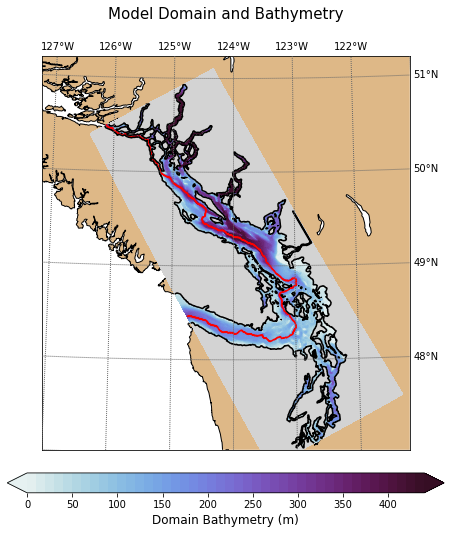

In [7]:
#set plot parameters
#scaling factor 
fact = 1
fs = 12
dicmin_twg = 1900
dicmax_twg = 2300
dicmin_surf = 0
dicmax_surf = 450
dicstep = 10

fig = plt.figure(figsize=(6.5*fact, 7.5*fact))

#domain plot - BR run summer average
ax1 = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1) 

w_map = [-127, -121, 47, 51.2]
m = plot_basemap(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  
#define data to plot as the surface level of the summer dataset
tdat_p = grid['Bathymetry'][:,:]
mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(dicmin_surf, dicmax_surf, dicstep), \
                 cmap=cm.dense, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)
plot_thalweg(ax1, x, y)
ax1.set_title('Model Domain and Bathymetry',fontsize = fs+3, y=1.08)

cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.1, pad=0.05)
cbar.set_label(label='Domain Bathymetry (m)', size=fs)
#ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')

plt.tight_layout()
#fig.savefig('SF_modeldomain.png',dpi = 300)

#### 